### Notebook
- Creates Figure 3: Sex-specific exposure analysis with mutational signatures

In [1]:
import sys
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [18]:
import PIL

### 1. Load data

In [2]:
# Signature data 
total_mutations = pd.read_csv('../data/mutational_signatures/total_mutations.tsv',sep='\t')
simple_mutations = pd.read_csv('../data/mutational_signatures/simple_mutations.tsv',sep='\t')
mutational_signatures = pd.read_csv('../data/mutational_signatures/mutational_signatures.tsv',sep='\t')

In [3]:
# Load mutation and clinical data
binary_mut_df = pd.read_csv('../data/patient_binary_driver.expressed_only.matrix', sep='\t', index_col=0)
clinical_df = pd.read_csv('../data/all_clinical_tcga.txt.gz', sep='\t', index_col=0)

### 2. Subplot A: Sex analysis
- Examine M/F log ratios

In [4]:
mutational_signatures['Log2_Ratio'] = np.log2(mutational_signatures['Mean Ratio (Male / Female)'])
simple_mutations['Log2_Ratio'] = np.log2(simple_mutations['Mean Ratio (Male / Female)'])
total_mutations['Log2_Ratio'] = np.log2(total_mutations['Mean Ratio (Male / Female)'])

In [5]:
mutational_signatures['cancer_signature'] = [mutational_signatures['Cancer Type'].values[i] + ' ' + mutational_signatures['Mutational Signatures'].values[i].split('-')[1] for i in range(len(mutational_signatures))]
mutational_signatures['Signature_short'] = [x.split('-')[1] for x in mutational_signatures['Mutational Signatures'].values]

In [6]:
panel_a_data = mutational_signatures[['Cancer Type', 'Signature_short', 'Log2_Ratio']]
panel_a_data = panel_a_data.pivot('Cancer Type', 'Signature_short', 'Log2_Ratio')

panel_a_data.head(2)

Signature_short,01,02,04,05,07a,07b,07c,07d,10b,11,...,38,39,40,42,45,49,52,54,59,60
Cancer Type,,,,,,,,,,,,,,,,,,,,,
ACC,0.584963,0.389567,NaN,0.321928,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BLCA,0.111031,0.226509,NaN,0.111031,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3. Subplot B: Driver mutation %
- Examine M/F log ratios

In [7]:
mutation_categories = pd.read_csv('../data/mutational_signatures/driver_mutation_signatures.tsv',
                        sep='\t', header=None)
mutation_categories.columns = ['Mutational Signature', 'Number of Mutations',
                              'Percentage of Mutations', 'Function']
mutation_categories['Percentage of Mutations'] = pd.Series([x[:-1] for x in mutation_categories['Percentage of Mutations']]).astype(float)
mutation_categories['Signature'] = [x.split('-')[1] for x in mutation_categories['Mutational Signature'].values]

mutation_categories.head(2)

,Mutational Signature,Number of Mutations,Percentage of Mutations,Function,Signature
0,Signature Subs-01,196,19.6,Clock-like mutations that accumulate with age,01
1,Signature Subs-02,36,3.6,Aberrant APOBEC activity,02


### 4. Subplot C: Age analysis
- See which tumor types have 
    - C>T mutations (predominant in Signature 1)
    - T>C mutations (predominant in Signature 5)

In [8]:
sig_color_dict = {
    1: 'red',
    0: 'grey' }
base_sub_dict = {
    'G>A': 'C>A',
    'A>G': 'T>G',
    'G>C': 'C>T',
    'A>C': 'T>C',
    'A>T': 'T>A',
    'G>T': 'C>T'}

In [9]:
# Load all driver mutations' base changes
driver_coord_df = pd.read_csv('../data/driver_mutation_coordinates.csv')

# Extract base changes, create combined column
driver_coord_df['Base_change'] = driver_coord_df[['Reference_Allele', 'Tumor_Seq_Allele2']].apply(lambda x: '>'.join(x), axis=1)
driver_coord_df['combined'] = driver_coord_df['combined'].apply(lambda x: 'M_{}'.format(x))
driver_coord_df['Base_substitution'] = [change if change not in base_sub_dict.keys() else base_sub_dict[change] for change in driver_coord_df['Base_change'].values]

driver_coord_df.head(2)

,Hugo_Symbol,Protein_position,Amino_acids,Chromosome,Start_Position,Strand,Reference_Allele,Tumor_Seq_Allele2,combined,Base_change,Base_substitution
0,TP53,281/393,D/E,chr17,7673777,+,G,C,M_TP53_D281E,G>C,C>T
1,TP53,272/393,V/M,chr17,7673806,+,C,T,M_TP53_V272M,C>T,C>T


In [10]:
# Compare all allele affinities for C>T/T>C compared to other mutations
aff_df_I = pd.read_csv('../data/all_alleles.driver_mut.class_i.affinities.tsv.gz', sep='\t', index_col=0)
aff_df_II = pd.read_csv('../data/all_alleles.driver_mut.class_ii.affinities.tsv.gz', sep='\t', index_col=0)

In [11]:
# Subset mutations
ct_muts = driver_coord_df[driver_coord_df['Base_change'].isin(['C>T', 'T>C'])].combined.values
non_ct_muts = driver_coord_df[~driver_coord_df['Base_change'].isin(['C>T', 'T>C'])].combined.values

# affinities
ct_aff_I = aff_df_I.loc[ct_muts]
ct_aff_I['class'] = 'I'
ct_aff_I['mut_type'] = 'C>T/T>C mutations'

ct_aff_II = aff_df_II.loc[ct_muts]
ct_aff_II['class'] = 'II'
ct_aff_II['mut_type'] = 'C>T/T>C mutations'

non_ct_aff_I = aff_df_I.loc[non_ct_muts]
non_ct_aff_I['class'] = 'I'
non_ct_aff_I['mut_type'] = 'Other mutations'

non_ct_aff_II = aff_df_II.loc[non_ct_muts]
non_ct_aff_II['class'] = 'II'
non_ct_aff_II['mut_type'] = 'Other mutations'

In [12]:
# Consolidate into plotting df
panel_c_df = ct_aff_I.append(ct_aff_II.append(non_ct_aff_I.append(non_ct_aff_II, sort=True), sort=True),sort=True)
panel_c_df = pd.melt(panel_c_df, id_vars=['mut_type', 'class'])
panel_c_df.head(2)

,mut_type,class,variable,value
0,C>T/T>C mutations,I,DRB1_0101,NaN
1,C>T/T>C mutations,I,DRB1_0101,NaN


In [13]:
# p_I = mannwhitneyu(df[(df['class']=='I') & (df['mut_type']=='C>T/T>C')].dropna().value.values,
#                    df[(df['class']=='I') & (df['mut_type']=='other')].dropna().value.values).pvalue
# p_II = mannwhitneyu(df[(df['class']=='II') & (df['mut_type']=='C>T/T>C')].dropna().value.values,
#                    df[(df['class']=='II') & (df['mut_type']=='other')].dropna().value.values).pvalue

# plt.figure(figsize=(3,4))
# sns.boxplot(x='class', y='value', hue='mut_type', data=df, palette='Set3')
# plt.xlabel(''), plt.xticks([0,1], ['MHC-I\np<{:.3}'.format(p_I), 
#                                    'MHC-II\np<{:.3}'.format(p_II)])
# plt.ylabel('Allele-specific best-rank (BR) score')
# # plt.title('365 C>T/T>C driver mutations, 635 other')
# plt.legend(loc='upper right')

# savepath = '/cellar/users/andreabc/Data/hla_sex/figures/3_CT_mutation_affinities.boxplot.pdf'
# print('Saving to {}'.format(savepath)), plt.savefig(savepath, bbox_inches='tight')
# plt.show()

### 5. Plot panel

Saving to ../figures/Figure_3.zoomed.png


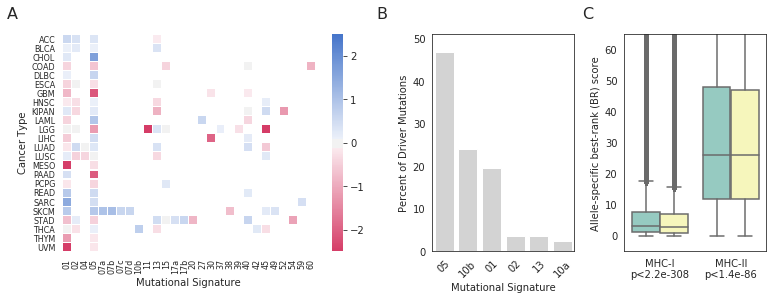

In [22]:
plt.figure(figsize=(11,4))

#############################################
# A. Sex-ratios of mut. signatures by tumor #
#############################################
plt.subplot2grid((1, 8), (0, 0), colspan=4, aspect=1)

sns.heatmap(panel_a_data, cmap=sns.diverging_palette(1, 255, as_cmap=True), linewidths=0.1, 
            center=0, vmin=-2.5, vmax=2.5, xticklabels=True, yticklabels=True)

plt.xticks(rotation=90, fontsize=8), 
plt.xlabel('Mutational Signature')
plt.yticks(fontsize=8)

################################################
# B. Mutational signatures in driver mutations #
################################################
plt.subplot2grid((1, 8), (0, 4), colspan=2)

sns.barplot(x='Signature', y='Percentage of Mutations', 
            data=mutation_categories.sort_values('Percentage of Mutations', ascending=False),
            color='lightgrey')

plt.xticks(rotation=45)
plt.xlabel('Mutational Signature'), plt.ylabel('Percent of Driver Mutations')
plt.ylim(0,51)
plt.subplots_adjust(wspace=0, hspace=0)

###############################
# C. Allele-specific affinity #
###############################
plt.subplot2grid((1, 8), (0, 6), colspan=2)

# p_I = mannwhitneyu(panel_c_df[(panel_c_df['class']=='I') & (panel_c_df['mut_type']=='C>T/T>C mutations')].dropna().value.values,
#                    panel_c_df[(panel_c_df['class']=='I') & (panel_c_df['mut_type']=='Other mutations')].dropna().value.values).pvalue
# p_II = mannwhitneyu(panel_c_df[(panel_c_df['class']=='II') & (panel_c_df['mut_type']=='C>T/T>C mutations')].dropna().value.values,
#                    panel_c_df[(panel_c_df['class']=='II') & (panel_c_df['mut_type']=='Other mutations')].dropna().value.values).pvalue

ax = sns.boxplot(x='class', y='value', hue='mut_type', data=panel_c_df, palette='Set3')
plt.xlabel(''), plt.xticks([0,1], ['MHC-I\np<{:.2}'.format(max(p_I, sys.float_info.min)), 
                                   'MHC-II\np<{:.2}'.format(max(p_II, sys.float_info.min))])
plt.ylabel('Allele-specific best-rank (BR) score')
plt.ylim(-5,65)
ax.get_legend().remove()


# letters
plt.text(-9.2,70, 'A', fontsize=16)
plt.text(-4,  70, 'B', fontsize=16)
plt.text(-1.1,70, 'C', fontsize=16)

# save
plt.tight_layout(pad=1.3)

savepath = '../figures/Figure_3.zoomed.png'
print('Saving to {}'.format(savepath))
plt.savefig(savepath, bbox_inches='tight', dpi=1200)
plt.show()

In [15]:
panel_c_df.dropna().pivot_table(index='mut_type', columns='class', values='value', aggfunc='median')

class,I,II
mut_type,,
C>T/T>C mutations,3.3241,26.0
Other mutations,2.9550,26.0


In [14]:
panel_c_df.dropna().pivot_table(index='mut_type', columns='class', values='variable', aggfunc='count')

class,I,II
mut_type,,
C>T/T>C mutations,1063975,2051300
Other mutations,1851025,3568700
